<h1>introduction</h1>


The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets We will try here using Python libraries to achieve this goal.

In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from warnings import filterwarnings
filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#nltk.download('wordnet')


In [2]:
import sklearn
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import set_config

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from textblob import Word
from textblob import TextBlob

import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
%%time
train = pd.read_csv('nlp_train.csv')
test = pd.read_csv('nlp_test.csv')
print("\nDATASETS WERE SUCCESFULLY LOADED...")


DATASETS WERE SUCCESFULLY LOADED...
Wall time: 91.7 ms


<h2>Data exploration</h2>

Here we will start the stage of exploring the data and trying to learn more about it, and by reviewing it, we will define the next steps¶

In [4]:
train.head(n = 5).style.background_gradient(cmap = "spring")

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [5]:
#The first five rows of test set
test.head(n = 5).style.background_gradient(cmap = "spring")

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


In [6]:
print("Train set shape: {} and test set shape: {}".format(train.shape, test.shape))

Train set shape: (31962, 3) and test set shape: (17197, 2)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [8]:
#Check whether there are duplicated value!!!!
print("Totally there are {} duplicated values in train_set".format(train.duplicated().sum()))

Totally there are 0 duplicated values in train_set


In [9]:
train.groupby("label").count().style.background_gradient(cmap = "spring")

,id,tweet
label,,
0,29720,29720
1,2242,2242


In [10]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [11]:
print(f'Checking for null values in data....... \n{train.isnull().any()}')

Checking for null values in data....... 
id       False
label    False
tweet    False
dtype: bool


In [12]:
pos = 100*len(train.loc[train['label']==0,'label'])/len(train['label'])
neg = 100*len(train.loc[train['label']==1,'label'])/len(train['label'])
print(f'Percentage of Negative Sentiment tweets is {pos}')
print(f'Percentage of Postitive Sentiment tweets is {neg}')
print('\nClearly, The data is heavily Imbalanced')

Percentage of Negative Sentiment tweets is 92.98542018647143
Percentage of Postitive Sentiment tweets is 7.014579813528565

Clearly, The data is heavily Imbalanced


In [13]:
# Understanding the sentiments in the data #
train[train['label']==0].head(20) 
# Class 0 : shows the list of positive sentiments

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [14]:
# Understanding the sentiments in the data #
train[train['label']==1].head(20) 
# Class 1  : Negative sentiments of the user 

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


In [15]:
train_len = train['tweet'].str.len()
test_len = test['tweet'].str.len()
print("train data length :" , train_len)
print("test data length :" , test_len)

train data length : 0        102
1        122
2         21
3         86
4         39
        ... 
31957     68
31958    131
31959     63
31960     67
31961     32
Name: tweet, Length: 31962, dtype: int64
test data length : 0         90
1        101
2         71
3        142
4         93
        ... 
17192    108
17193     96
17194    145
17195    104
17196     64
Name: tweet, Length: 17197, dtype: int64


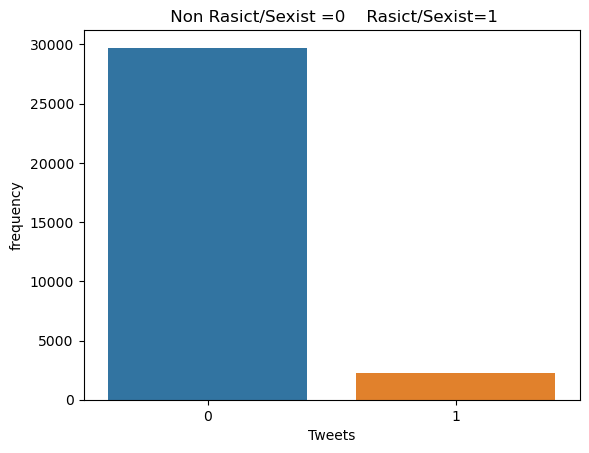

In [16]:
sns.countplot(x= train['label'],data = train)
plt.title(' Non Rasict/Sexist =0    Rasict/Sexist=1')
plt.xlabel('Tweets')
plt.ylabel("frequency")
plt.show()

In [17]:
c=CountVectorizer(stop_words='english')
word=c.fit_transform(train.tweet)
summation=word.sum(axis=0)
print(summation)

[[ 51  28   2 ... 272   1   2]]


In [18]:
freq=[(word,summation[0,i]) for word,i in c.vocabulary_.items()]
freq=sorted(freq,key=lambda x:x[1],reverse=True)
frequency = pd.DataFrame(freq, columns=['word', 'freq'])
print(frequency)

           word   freq
0          user  17577
1          love   2749
2           day   2311
3           amp   1776
4         happy   1686
...         ...    ...
41099       isz      1
41100  airwaves      1
41101    mantle      1
41102   shirley      1
41103   chisolm      1

[41104 rows x 2 columns]


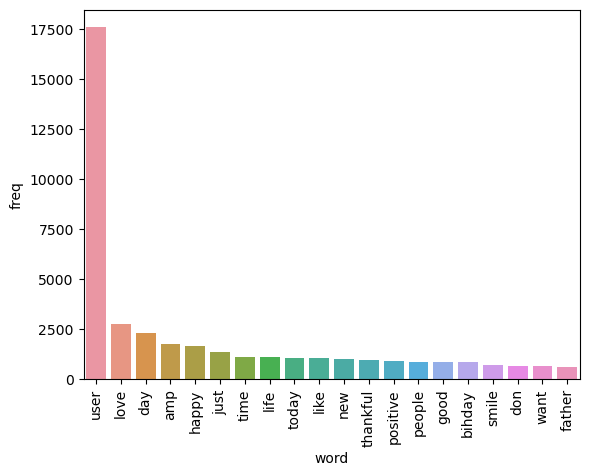

In [19]:
sns.barplot(frequency.head(20)['word'],frequency.head(20)['freq'])
plt.xticks(rotation='vertical')
plt.show()

In [20]:
train.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

Count number of words

In [21]:
#Count number of words
def num_of_words(df):
    df['word_count'] = df['tweet'].apply(lambda x : len(str(x).split(" ")))
    print(df[['tweet','word_count']].head())

In [22]:
num_of_words(train)

                                               tweet  word_count
0   @user when a father is dysfunctional and is s...          21
1  @user @user thanks for #lyft credit i can't us...          22
2                                bihday your majesty           5
3  #model   i love u take with u all the time in ...          17
4             factsguide: society now    #motivation           8


In [23]:
num_of_words(test)

                                               tweet  word_count
0  #studiolife #aislife #requires #passion #dedic...          12
1   @user #white #supremacists want everyone to s...          20
2  safe ways to heal your #acne!!    #altwaystohe...          15
3  is the hp and the cursed child book up for res...          24
4    3rd #bihday to my amazing, hilarious #nephew...          18


average word length

In [24]:
def avg_word(sentence):
    words = sentence.split()    
    return (sum(len(word) for word in words)/len(words))

In [25]:
def avg_word_length(df):
    df['avg_word'] = df['tweet'].apply(lambda x: avg_word(x))
    print(df[['tweet','avg_word']].head())

In [26]:
avg_word_length(train)

                                               tweet  avg_word
0   @user when a father is dysfunctional and is s...  4.555556
1  @user @user thanks for #lyft credit i can't us...  5.315789
2                                bihday your majesty  5.666667
3  #model   i love u take with u all the time in ...  4.928571
4             factsguide: society now    #motivation  8.000000


In [27]:
avg_word_length(test)

                                               tweet  avg_word
0  #studiolife #aislife #requires #passion #dedic...  8.777778
1   @user #white #supremacists want everyone to s...  5.125000
2  safe ways to heal your #acne!!    #altwaystohe...  6.333333
3  is the hp and the cursed child book up for res...  5.409091
4    3rd #bihday to my amazing, hilarious #nephew...  5.066667


In [28]:
stop=set(stopwords.words('english'))
stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [29]:
def stop_words(df):
    df['stopwords'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
    print(df[['tweet','stopwords']].head())

In [30]:
stop_words(test)

                                               tweet  stopwords
0  #studiolife #aislife #requires #passion #dedic...          1
1   @user #white #supremacists want everyone to s...          4
2  safe ways to heal your #acne!!    #altwaystohe...          2
3  is the hp and the cursed child book up for res...          8
4    3rd #bihday to my amazing, hilarious #nephew...          4


In [31]:
stop_words(train)

                                               tweet  stopwords
0   @user when a father is dysfunctional and is s...         10
1  @user @user thanks for #lyft credit i can't us...          5
2                                bihday your majesty          1
3  #model   i love u take with u all the time in ...          5
4             factsguide: society now    #motivation          1


In [32]:
def hash_tags(df):
    df['hashtags'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
    print(df[['tweet','hashtags']].head())

In [33]:
hash_tags(train)

                                               tweet  hashtags
0   @user when a father is dysfunctional and is s...         1
1  @user @user thanks for #lyft credit i can't us...         3
2                                bihday your majesty         0
3  #model   i love u take with u all the time in ...         1
4             factsguide: society now    #motivation         1


In [34]:
#Convert uppercase letters to lowercase letters in "tweet" columns
train["tweet"] = train["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
test["tweet"] = test["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
print("\nCONVERTED SUCCESFULLY...")


CONVERTED SUCCESFULLY...


In [35]:
#Delete punctuation marks from "tweet" columns
train["tweet"] = train["tweet"].str.replace('[^\w\s]','')
test["tweet"] = test["tweet"].str.replace('[^\w\s]','')
print("\nDELETED SUCCESFULLY...",)


DELETED SUCCESFULLY...


In [36]:
#Delete numbers from "tweet" columns
train['tweet'] = train['tweet'].str.replace('\d','')
test['tweet'] = test['tweet'].str.replace('\d','')
print("NUMBERS DELETED SUCCESFULLY...")

NUMBERS DELETED SUCCESFULLY...


In [37]:
sw = stopwords.words("english")
train['tweet'] = train['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
test['tweet'] = test['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
print("\nSTOPWORDS DELETED SUCCESFULLY...")


STOPWORDS DELETED SUCCESFULLY...


In [38]:
train = train.drop("id", axis = 1)
test = test.drop("id", axis = 1)
print("\n 'ID' COLUMN DROPPED SUCCESFULLY...")


 'ID' COLUMN DROPPED SUCCESFULLY...


In [39]:
def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    print(df['tweet'].head())

In [40]:
lower_case(train)

0    user father dysfunctional selfish drags kids d...
1    user user thanks lyft credit cant use cause do...
2                                       bihday majesty
3                model love u take u time urð ðððð ððð
4                        factsguide society motivation
Name: tweet, dtype: object


In [41]:
lower_case(test)

0    studiolife aislife requires passion dedication...
1    user white supremacists want everyone see new ...
2    safe ways heal acne altwaystoheal healthy healing
3    hp cursed child book reservations already yes ...
4    rd bihday amazing hilarious nephew eli ahmir u...
Name: tweet, dtype: object


frequent words removal

In [44]:
freq = pd.Series(' '.join(train['tweet']).split()).value_counts()[:10]
freq = list(freq.index)
def frequent_words_removal(df):    
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    print(df['tweet'].head())

In [45]:
frequent_words_removal(train)

In [46]:
frequent_words_removal(test)

rare words removal

In [49]:
rare = pd.Series(' '.join(train['tweet']).split()).value_counts()[-10:]
rare = list(rare.index)
def rare_words_removal(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))
    print(df['tweet'].head())

In [50]:
rare_words_removal(train)

In [51]:
rare_words_removal(test)

spell correction

In [52]:
def spell_correction(df):
    return df['tweet'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [53]:
spell_correction(train)

0    user father dysfunctional selfish drags kiss d...
1    user user thanks left credit can use cause don...
2                                       midday majesty
3                 model love u take u time or ðððð ððð
4                        factsguide society motivation
Name: tweet, dtype: object

In [54]:
spell_correction(test)

0    studiolife dislike requires passion education ...
1    user white supremacists want everyone see new ...
2    safe ways heal acne altwaystoheal healthy healing
3    he cursed child book reservations already yes ...
4    rd midday amazing hilarious nephew epi their u...
Name: tweet, dtype: object

In [55]:
x = train["tweet"]
y = train["label"]
train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)
print("\nDIVIDED SUCCESFULLY...")


DIVIDED SUCCESFULLY...


In [56]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)

x_train_count = vectorizer.transform(train_x).astype('float32')
x_test_count = vectorizer.transform(test_x).astype('float32')

x_train_count.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [57]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

x_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print("\nLogistic regression model with 'count-vectors' method")
print("Accuracy ratio: ",accuracy)


Logistic regression model with 'count-vectors' method
Accuracy ratio:  0.9466614420062698


In [59]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print("\nLogistic regression model with 'tf-idf' method")
print("Accuracy ratio: ",accuracy)


Logistic regression model with 'tf-idf' method
Accuracy ratio:  0.9297683189655173


In [60]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_count,train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print("\nXGBoost model with 'count-vectors' method")
print("Accuracy ratio: ", accuracy)


XGBoost model with 'count-vectors' method
Accuracy ratio:  0.9418123040752351


In [61]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(lgbm_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print("\nLight GBM model with 'tf-idf' method")
print("Accuracy ratio: ", accuracy)


Light GBM model with 'tf-idf' method
Accuracy ratio:  0.9350857170846394


In [62]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(x_train_count,train_y)
accuracy = model_selection.cross_val_score(lgbm_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print("\nLight GBM model with 'tf-idf' method")
print("Accuracy ratio: ", accuracy)


Light GBM model with 'tf-idf' method
Accuracy ratio:  0.9339914772727271


In [63]:
y = train_y
X = x_train_count.astype("float64")

lgbm_roc_auc = roc_auc_score(y, lgbm_model.predict(X))
log_roc_auc = roc_auc_score(y, log_model.predict(X))
xgb_roc_auc = roc_auc_score(y, xgb_model.predict(X))



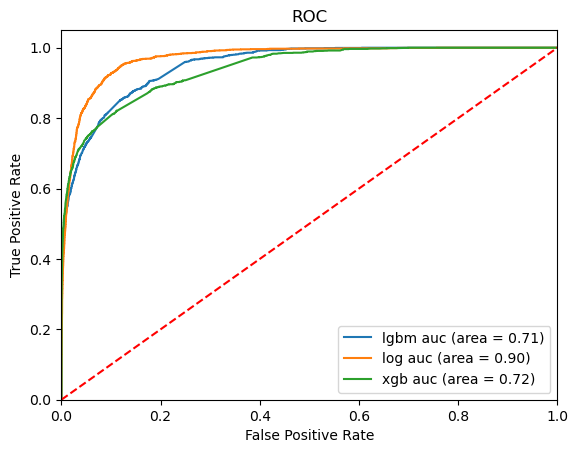

In [64]:
lgbm_fpr, lgbm_tpr, lgbm_thresholds = roc_curve(y, lgbm_model.predict_proba(X)[:,1])
log_fpr, log_tpr, log_thresholds = roc_curve(y, log_model.predict_proba(X)[:,1])
xgb_fpr,xgb_tpr, xgb_thresholds = roc_curve(y, xgb_model.predict_proba(X)[:,1])

plt.figure()
plt.plot(lgbm_fpr, lgbm_tpr, label='lgbm auc (area = %0.2f)' % lgbm_roc_auc)
plt.plot(log_fpr, log_tpr, label='log auc (area = %0.2f)' % log_roc_auc)
plt.plot(xgb_fpr, xgb_tpr, label='xgb auc (area = %0.2f)' % xgb_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

In [65]:
#Look at the first 5 rows of the test set
test.head()

,tweet,word_count,avg_word,stopwords
0,studiolife aislife requires passion dedication...,12,8.777778,1
1,user white supremacists want everyone see new ...,20,5.125000,4
2,safe ways heal acne altwaystoheal healthy healing,15,6.333333,2
3,hp cursed child book reservations already yes ...,24,5.409091,8
4,rd bihday amazing hilarious nephew eli ahmir u...,18,5.066667,4


In [66]:
#Here we encode values of "tweet" column of test set with "count-vectors" method.
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
test_set = vectorizer.transform(test["tweet"])
test_set.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

(-0.5, 499.5, 499.5, -0.5)

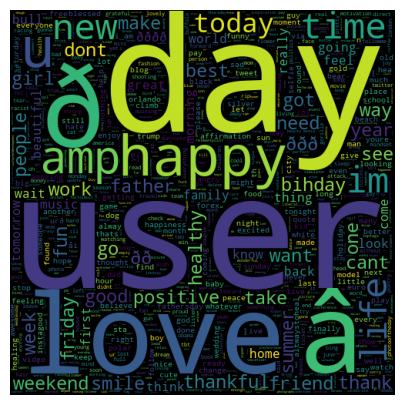

In [67]:
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from PIL import Image

#tw_mask = np.array(Image.open('../input/masksforwordclouds/twitter_mask3.jpg'))

text = " ".join(i for i in train.tweet)

wc = WordCloud(background_color = "black",
               width = 500,
               height = 500,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [5,5])
plt.imshow(wc)
plt.axis("off")

In [68]:
import pickle
pickle.dump(vectorizer,open('vectorizer.pkl','wb'))
pickle.dump(log,open('model.pkl','wb'))